In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [5]:
figsize = (8, 4)
title_fontsize = 20
tick_label_fontsize = 14
legend_fontsize = 14
axis_label_fontsize = 16
text_fontsize = 18

# Actograms

In [6]:
data_path = 'data/light_schedules/'

In [7]:
time = np.load(f'{data_path}/time.npy')
regular_early_light = np.load(f'{data_path}/regular_early_light.npy')
regular_late_light = np.load(f'{data_path}/regular_late_light.npy')
chang14_ebook_first_light = np.load(f'{data_path}/chang14_ebook_first_light.npy')
chang14_ebook_second_light = np.load(f'{data_path}/chang14_ebook_second_light.npy')
chang14_high_ebook_first_light = np.load(f'{data_path}/chang14_high_ebook_first_light.npy')
chang14_high_ebook_second_light = np.load(f'{data_path}/chang14_high_ebook_second_light.npy')
realistic_ebook_first_light = np.load(f'{data_path}/realistic_ebook_first_light.npy')
realistic_ebook_second_light = np.load(f'{data_path}/realistic_ebook_second_light.npy')

In [ ]:
dt = 0.005
simulation_days = 14

light_arrays_to_plot = {
    'Regular early light': regular_early_light,
    'Regular late light': regular_late_light,
    'Chang14 ebook first light': chang14_ebook_first_light,
    'Chang14 ebook second light': chang14_ebook_second_light,
    'Chang14 high ebook first light': chang14_high_ebook_first_light,
    'Chang14 high ebook second light': chang14_high_ebook_second_light,
    'Realistic ebook first light': realistic_ebook_first_light,
    'Realistic ebook second light': realistic_ebook_second_light
}

hours_per_day = 24
colors_cmap = ["black", "gold"]
position = [0, 1]

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", list(zip(position, colors_cmap)))

def next_multiple_of_ten(n):
    return ((n + 9) // 10) * 10

def plot_actogram_double_plotted(light, dt, simulation_days, ebook_first=True,
                                 vmax=None, save_name=None):
    light = np.array(light)

    # DLMO collection time on 6 and day 12, set those values to NaN
    dlmo_collection = np.ones_like(light)
    dlmo_collection_masks = [
        (int(len(light) * 0.75 / 14.0), int(len(light) * 0.9167 / 14.0)),
        (int(len(light) * 1.25 / 14.0), int(len(light) * 1.4167 / 14.0)),
        (int(len(light) * 6.75 / 14.0), int(len(light) * 6.9167 / 14.0)),
        (int(len(light) * 7.25 / 14.0), int(len(light) * 7.4167 / 14.0)),
        (int(len(light) * 12.75 / 14.0), int(len(light) * 12.9167 / 14.0)),
        (int(len(light) * 13.25 / 14.0), int(len(light) * 13.4167 / 14.0)),

    ]
    for dlmo_collection_mask in dlmo_collection_masks:
        dlmo_collection[dlmo_collection_mask[0]:dlmo_collection_mask[1]] = np.nan
    dlmo_collection = dlmo_collection.reshape(
        (simulation_days, int(hours_per_day / dt)))

    custom_cmap.set_bad(color='lightcoral')  # Set color for NaNs

    if vmax is None:
        vmax = next_multiple_of_ten(np.max(light))
    norm = colors.Normalize(vmin=0,
                    vmax=vmax)
    

    amplitude_delta = light
    amplitude_delta = amplitude_delta.reshape(-1, 1)

    scaled_data = amplitude_delta.reshape(
        (simulation_days, int(hours_per_day / dt))) * dlmo_collection

    double_plotted_data = np.zeros(
        (simulation_days, int(hours_per_day / dt * 2)))

    # Last day does not have a "next day" to concatenate
    for day in range(simulation_days - 1):
        double_plotted_data[day] = np.concatenate(
            (scaled_data[day], scaled_data[day + 1]))
    double_plotted_data[-1] = np.concatenate(
        (scaled_data[-1], np.zeros_like(scaled_data[-1])))

    fig, ax = plt.subplots(figsize=figsize)

    # norm.autoscale_None([np.nan])  # Auto-scale to include NaN
    # Log norm including nan
    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=0, vmax=vmax)
    norm.autoscale_None([np.nan])  # Auto-scale to include NaN


    cax = ax.imshow(double_plotted_data, aspect='auto',
                    cmap=custom_cmap, norm=norm , interpolation='none',
                    rasterized=True)

    cbar = fig.colorbar(cax, ax=ax, pad=0.01)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Light level', rotation=270, fontsize=axis_label_fontsize)

    # Adjust ticks for 48-hour x-axis
    dt_plot = 4
    x_ticks = np.arange(0, hours_per_day / dt * 2, dt_plot / dt)

    x_tick_labels = [str(int(x % hours_per_day))
                     for x in np.arange(0, hours_per_day * 2, dt_plot)]
    ax.set_xlabel('Local time', fontsize=axis_label_fontsize)
    ax.set_ylabel('Day', fontsize=axis_label_fontsize)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=tick_label_fontsize)

    day_step = 2
    ax.set_yticks(np.arange(0, simulation_days, day_step))
    ax.set_yticklabels(np.arange(1, simulation_days + 1, day_step),
                       fontsize=tick_label_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Cbar ticks
    cbar_label_numbers = [0, 1, 10, 100, 500]
    cbar.set_ticks(cbar_label_numbers)
    cbar_labels = [f"{x}" for x in cbar_label_numbers]
    cbar.set_ticklabels(cbar_labels)

    # Cbar title fontsize and location
    cbar.ax.yaxis.label.set_fontsize(axis_label_fontsize)
    cbar.ax.yaxis.set_label_coords(5.5, 0.5)

    # Ebook-book text
    kwargs_book = {'fontsize': text_fontsize, 'rotation': 90, 'alpha': 0.75, 'color': 'white'}
    kwargs_ebook = {'fontsize': text_fontsize, 'rotation': 90, 'alpha': 0.75, 'color': 'white'}
    if ebook_first:
        first_text_location_1 = (19.0 / dt, 4.4)
        first_text_location_2 = (43.0 / dt, 3.4)
        second_text_location_1 = (19.0 / dt, 10.0)
        second_text_location_2 = (43.0 / dt, 9.0)
        ax.text(*first_text_location_1, 'eBook', **kwargs_ebook)
        ax.text(*first_text_location_2, 'eBook', **kwargs_ebook)
        ax.text(*second_text_location_1, 'Book', **kwargs_book)
        ax.text(*second_text_location_2, 'Book', **kwargs_book)
    else:
        first_text_location_1 = (19.0 / dt, 4.0)
        first_text_location_2 = (43.0 / dt, 3.0)
        second_text_location_1 = (19.0 / dt, 10.4)
        second_text_location_2 = (43.0 / dt, 9.4)
        ax.text(*first_text_location_1, 'Book', **kwargs_book)
        ax.text(*first_text_location_2, 'Book', **kwargs_book)
        ax.text(*second_text_location_1, 'eBook', **kwargs_ebook)
        ax.text(*second_text_location_2, 'eBook', **kwargs_ebook)

    # Make last day white as a white box
    rect_x = 24.0 / dt
    rect_y = 12.5
    rect_width = 24 / dt
    rect_height = 1.0
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=0, edgecolor='black', facecolor='white')
    ax.add_patch(rect)

    # DLMO collection time text
    dlmo_text_locations = [
        (19.0 / dt, 0.25), (31.0 / dt, 0.25), (7.0 / dt, 1.25), 
        (43.0 / dt, 5.25), (19.0 / dt, 6.25), (31.0 / dt, 6.25), (7.0 / dt, 7.25), 
        (43.0 / dt, 11.25), (19.0 / dt, 12.25), (31.0 / dt, 12.25), (7.0 / dt, 13.25), 

    ]
    dlmo_text_locations = np.array(dlmo_text_locations) * np.array([1, 1.01])
    for dlmo_text_location in dlmo_text_locations:
        ax.text(*dlmo_text_location, 'CP', fontsize=text_fontsize * 0.75, alpha=0.5)
    
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
        core_save_name = save_name.split('.')[0]
        plt.savefig(f"{core_save_name}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

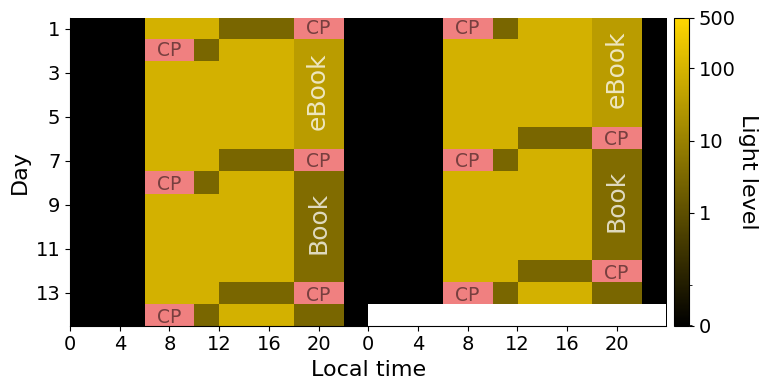

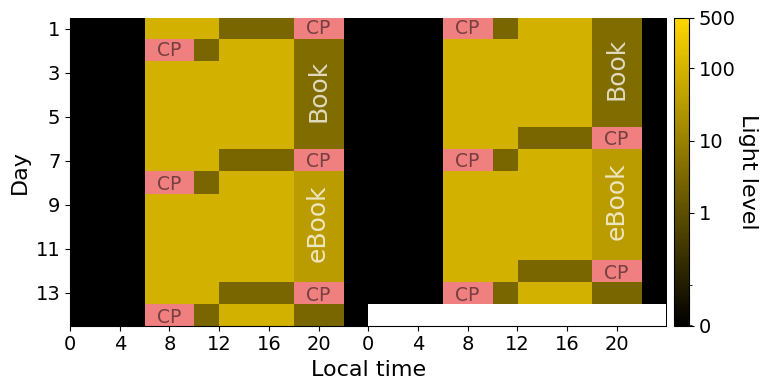

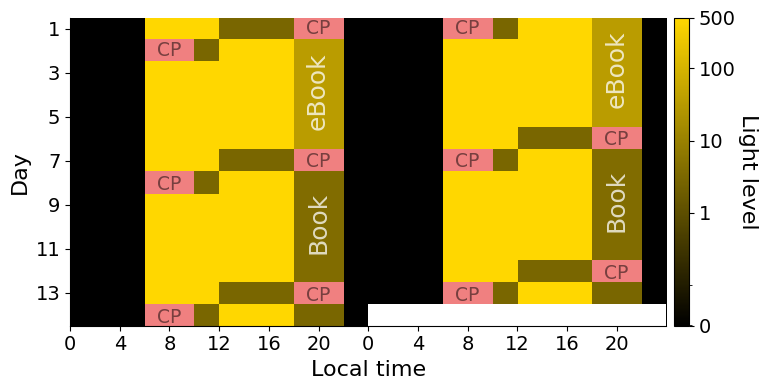

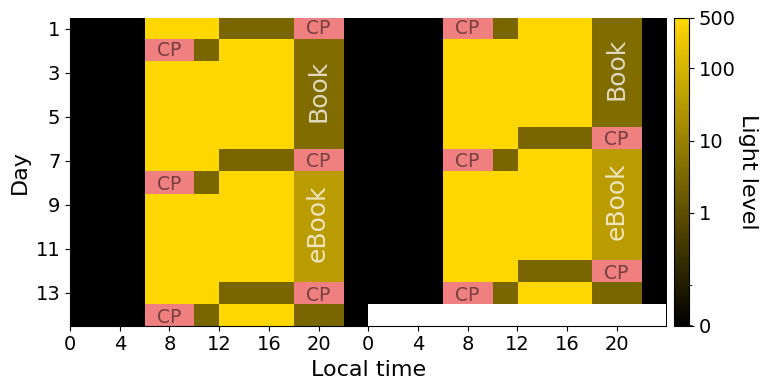

In [13]:
light_options = [
    chang14_ebook_first_light, chang14_ebook_second_light,
    chang14_high_ebook_first_light, chang14_high_ebook_second_light,
]
ebook_first_order = [
    True, False, True, False
]
names = [
    'ebook_first_low_indoor_light', 'ebook_second_low_indoor_light',
    'ebook_first_high_indoor_light', 'ebook_second_high_indoor_light',
]

for light, ebook_first in zip(light_options, ebook_first_order):
    save_name = f'figures/fig_1_{names.pop(0)}.pdf'
    plot_actogram_double_plotted(light, dt, simulation_days,
                                 ebook_first=ebook_first, vmax=500,
                                 save_name=save_name)

# Sleep onset evolution

In [14]:
simulation_features = pd.read_csv("data/chang14_selected_sleep_parameters/selected_sleep_parameters_simulation_features.csv", index_col=0)

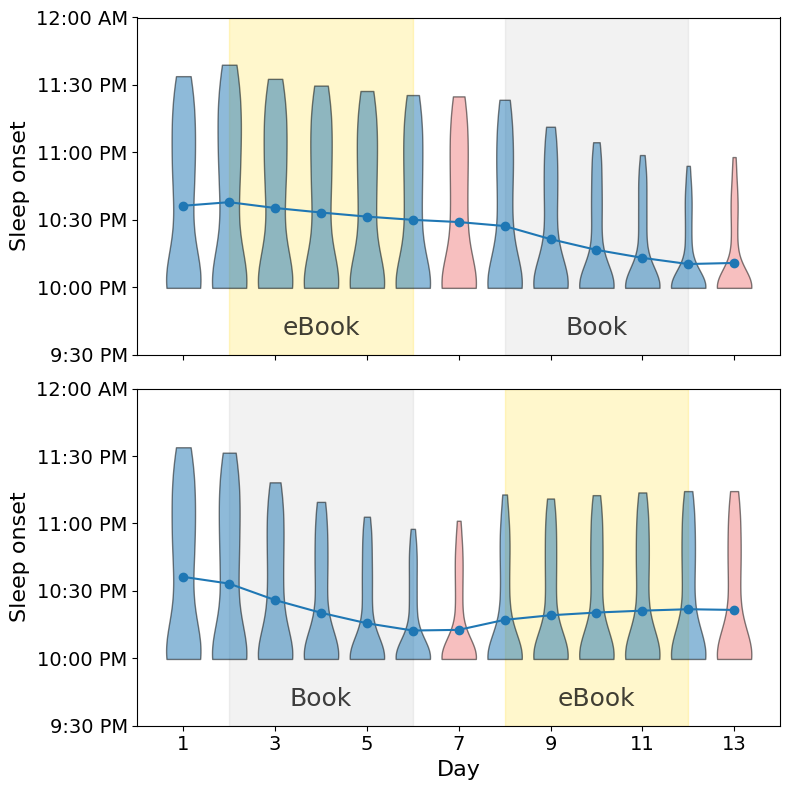

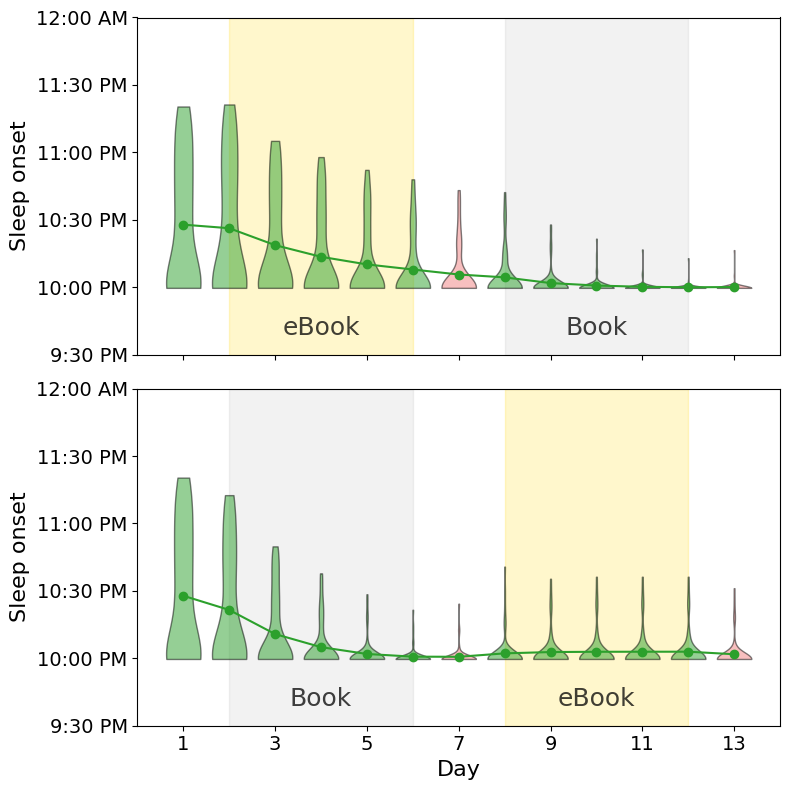

In [ ]:
light_condition = 'early_light'
simulation_condition_options = ['', 'high_']
marker_options = ['o', 'o']
color_options = ['tab:blue', 'tab:green']
labels = ['90 lux baseline', '500 lux baseline']
offset = [0.0, 0.0]
CP_color = 'lightcoral'

for idx, simulation_condition in enumerate(simulation_condition_options):

    fig, axs = plt.subplots(2, 1, figsize=(figsize[0], 2 * figsize[1]), sharey=True, sharex=True)

    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == f'chang14_{simulation_condition}ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == f'chang14_{simulation_condition}ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)

    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=color_options[idx],
                label=labels[idx], zorder=2)

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=color_options[idx],
                label=labels[idx], zorder=2)

    # Add points for individual data
    dataset_0 = []
    dataset_1 = []
    for day in ebook_first['day'].unique():
        sleep_onset_values_first = ebook_first[ebook_first['day'] == day]['sleep_onset']
        sleep_onset_values_second = ebook_second[ebook_second['day'] == day]['sleep_onset']
        dataset_0.append(sleep_onset_values_first)
        dataset_1.append(sleep_onset_values_second)

    v0 = axs[0].violinplot(dataset_0, positions=days, widths=0.75, showmeans=False, 
                    showextrema=False, showmedians=False)
    v1 = axs[1].violinplot(dataset_1, positions=days, widths=0.75, showmeans=False, 
                    showextrema=False, showmedians=False)

    for pc in v0['bodies']:
        pc.set_facecolor(color_options[idx])
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    for pc in v1['bodies']:
        pc.set_facecolor(color_options[idx])
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    # Set days 7 and 13 as CP color
    for idx, pc in enumerate(v0['bodies']):
        if idx == 6 or idx == 12:
            pc.set_facecolor(CP_color)

    for idx, pc in enumerate(v1['bodies']):
        if idx == 6 or idx == 12:
            pc.set_facecolor(CP_color)

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([21.5, 22, 22.5, 23, 23.5, 24])
    axs[0].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                           fontsize=tick_label_fontsize)
    axs[1].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                           fontsize=tick_label_fontsize)
    axs[1].tick_params(axis='x', labelsize=tick_label_fontsize)
    axs[0].set_ylim(21.5, 24)

    axs[0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
    axs[1].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
    axs[1].set_xlabel('Day', fontsize=axis_label_fontsize)

    axs[0].axvspan(2, 6, color='gold', alpha=0.2, label='eBook', zorder=0)
    axs[0].axvspan(8, 12, color='gray', alpha=0.1, label='Book', zorder=0)
    axs[1].axvspan(2, 6, color='gray', alpha=0.1, zorder=0)
    axs[1].axvspan(8, 12, color='gold', alpha=0.2, zorder=0)

    fig.subplots_adjust(wspace=0.05)

    # add text to each condition
    axs[0].text(4, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[0].text(10, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1].text(4, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1].text(10, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)

    plt.tight_layout()

    name = 'low' if simulation_condition == '' else 'high'
    plt.savefig(f'figures/fig_1_sleep_onset_evolution_{name}_indoor_light.pdf', bbox_inches='tight')
    plt.savefig(f'figures/fig_1_sleep_onset_evolution_{name}_indoor_light.png', bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

# Sleep latency

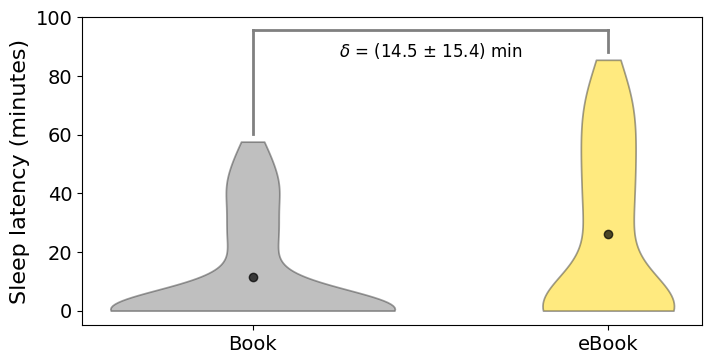

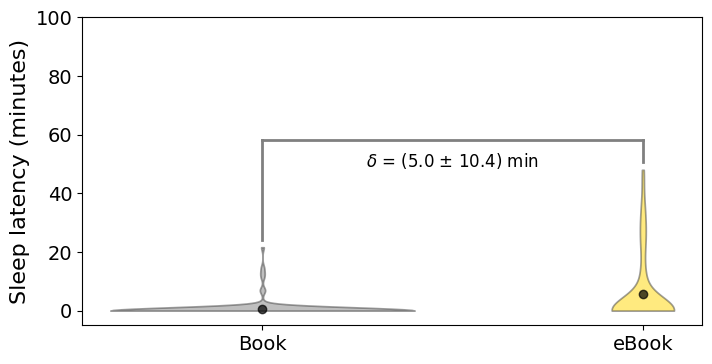

In [27]:
# Sleep latency at last condition day for Chang 14 schedule
simulation_condition_options  = ['', 'high_']
light_condition = 'early_light'
scheduled_bedtime = 22.0
marker_colors = ['tab:blue', 'tab:red']

df = pd.DataFrame()

for idx, simulation_condition in enumerate(simulation_condition_options):
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == f'chang14_{simulation_condition}ebook_first') |  \
                                      (simulation_features['simulation_condition'] == f'chang14_{simulation_condition}ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    condition_name = '90 lux baseline' if simulation_condition == '' else '500 lux baseline'
    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))


    fig, ax = plt.subplots(figsize=figsize)
    palette = {'Book': 'gray', 'eBook': 'gold'}

    plotting_parameters = {
        'data': sub_df,
        'x': 'condition',
        'y': 'sleep_latency',
        'cut': 0,
        'inner': None,
    }
    violin_colors = ['gray', 'gold']
    violin_tops = []

    sns.violinplot(**plotting_parameters, ax=ax)
    for violin  in ax.collections[::]:
        violin.set_alpha(0.5)
        violin.set_facecolor(violin_colors.pop(0))
        # top of the violin
        top = violin.get_paths()[0].vertices[:, 1].max()
        violin_tops.append(top)


    # Add point in the mean
    mean_values = sub_df.groupby('condition').mean()
    ax.scatter([0, 1], mean_values['sleep_latency'], color='black', zorder=1000, 
               alpha=0.7)

    # Calculate individual differences
    individual_differences = (ebook_sleep_latency - book_sleep_latency).values
    diff = np.mean(individual_differences)
    diff_std = np.std(individual_differences)

    # Annotation of difference between conditions
    line_top = max(violin_tops) + 10
    ax.plot([0, 1], [line_top, line_top], color='gray', linewidth=2)
    ax.plot([0, 0], [violin_tops[0] + 2.5, line_top], color='gray', linewidth=2)
    ax.plot([1, 1], [violin_tops[1] + 2.5, line_top], color='gray', linewidth=2)
    ax.annotate(fr'$\delta$ = ({diff:.1f} $\pm$ {diff_std:.1f}) min', xy=(0.5, line_top), xytext=(0.5, line_top - 7),
                fontsize=12, color='black', ha='center', va='center', zorder=1000)

    # Change x tick labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Book', 'eBook'], fontsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)

    ax.set_ylim(-5, 100)

    ax.set_ylabel('Sleep latency (minutes)', fontsize=axis_label_fontsize)
    ax.set_xlabel('')

    save_name_condition = 'low' if simulation_condition == '' else 'high'

    plt.savefig(f'figures/fig_1_sleep_latency_{save_name_condition}_indoor_light.pdf', bbox_inches='tight')
    plt.savefig(f'figures/fig_1_sleep_latency_{save_name_condition}_indoor_light.png', bbox_inches='tight', dpi=300)


    plt.show()
    plt.close()

In [24]:
individual_differences

simulation_idx
0     48.6
0     22.8
1      1.2
1      0.0
2     35.7
      ... 
58    21.3
59    31.5
59    17.4
60    31.2
60    17.1
Name: sleep_latency_minutes, Length: 122, dtype: float64

In [21]:
simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]

,day,simulation_condition,sleep_onset,sleep_duration,cbtmin,sleep_latency_minutes,daily_condition,light_condition
simulation_idx,,,,,,,,
0,12,chang14_high_ebook_first,21.995,6.430,1.570,0.0,Book,early_light
0,6,chang14_high_ebook_second,21.995,6.500,1.915,0.0,Book,early_light
1,12,chang14_high_ebook_first,21.995,6.325,1.570,0.0,Book,early_light
1,6,chang14_high_ebook_second,21.995,6.390,1.915,0.0,Book,early_light
2,12,chang14_high_ebook_first,21.995,6.600,1.570,0.0,Book,early_light
...,...,...,...,...,...,...,...,...
58,6,chang14_high_ebook_second,21.995,7.405,1.915,0.0,Book,early_light
59,12,chang14_high_ebook_first,21.995,7.735,1.570,0.0,Book,early_light
59,6,chang14_high_ebook_second,21.995,7.820,1.915,0.0,Book,early_light


In [22]:
simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') & 
                                             possible_simulation_conditions]

,day,simulation_condition,sleep_onset,sleep_duration,cbtmin,sleep_latency_minutes,daily_condition,light_condition
simulation_idx,,,,,,,,
0,6,chang14_high_ebook_first,22.220,6.555,2.485,13.2,eBook,early_light
0,12,chang14_high_ebook_second,21.995,6.510,1.980,0.0,eBook,early_light
1,6,chang14_high_ebook_first,21.995,6.490,2.485,0.0,eBook,early_light
1,12,chang14_high_ebook_second,21.995,6.390,1.980,0.0,eBook,early_light
2,6,chang14_high_ebook_first,21.995,6.800,2.485,0.0,eBook,early_light
...,...,...,...,...,...,...,...,...
58,12,chang14_high_ebook_second,21.995,7.445,1.980,0.0,eBook,early_light
59,6,chang14_high_ebook_first,22.365,7.630,2.485,21.9,eBook,early_light
59,12,chang14_high_ebook_second,22.145,7.825,1.980,8.7,eBook,early_light
